In [1]:
# https://www.kaggle.com/code/anshtanwar/ev-charging-import-and-eda
# https://www.kaggle.com/code/anshtanwar/ev-charging-duration

# datasets: 

# ev charging data
# 1 hourly ev charging loads and idle capacity data
# 2 hourly ev loads per user
# 3a hourly ev loads aggregated - private
# 3b hourly ev loads aggregated - shared

# weather data
# 7 norway trondheim exact location weather

# hourly ev charging loads and idle capacity data

In [2]:
import pandas as pd

# load dataset 1
df1_path = 'data/1 ev charging reports.csv'
df1 = pd.read_csv(df1_path, decimal=',', delimiter=';')

In [3]:
df1.head()

,session_ID,Garage_ID,User_ID,User_type,Shared_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,month_plugin,weekdays_plugin,Plugin_category,Duration_category
0,1,AdO3,AdO3-4,Private,NaN,21.12.2018 10:20,10,21.12.2018 10:23,10.0,0.30,0.050000,Dec,Friday,late morning (9-12),Less than 3 hours
1,2,AdO3,AdO3-4,Private,NaN,21.12.2018 10:24,10,21.12.2018 10:32,10.0,0.87,0.136667,Dec,Friday,late morning (9-12),Less than 3 hours
2,3,AdO3,AdO3-4,Private,NaN,21.12.2018 11:33,11,21.12.2018 19:46,19.0,29.87,8.216389,Dec,Friday,late morning (9-12),Between 6 and 9 hours
3,4,AdO3,AdO3-2,Private,NaN,22.12.2018 16:15,16,23.12.2018 16:40,16.0,15.56,24.419722,Dec,Saturday,late afternoon (15-18),More than 18 hours
4,5,AdO3,AdO3-2,Private,NaN,24.12.2018 22:03,22,24.12.2018 23:02,23.0,3.62,0.970556,Dec,Monday,late evening (21-midnight),Less than 3 hours


In [4]:
df1.describe()

,session_ID,Start_plugin_hour,End_plugout_hour,El_kWh,Duration_hours
count,6878.000000,6878.000000,6844.000000,6878.000000,6844.000000
mean,3439.500000,16.325240,12.546902,12.720744,11.504440
std,1985.651908,4.363108,5.256756,11.787938,14.148168
min,1.000000,0.000000,0.000000,0.010000,0.003333
25%,1720.250000,15.000000,7.000000,5.200000,2.789028
50%,3439.500000,17.000000,12.000000,9.050000,10.026250
75%,5158.750000,19.000000,17.000000,16.090000,15.221181
max,6878.000000,23.000000,23.000000,80.860000,255.029444


### preprocess data

In [5]:
# convert to datetime
df1['Start_plugin'] = pd.to_datetime(df1['Start_plugin'], format='%d.%m.%Y %H:%M')
df1['End_plugout'] = pd.to_datetime(df1['End_plugout'], format='%d.%m.%Y %H:%M')

#### inspect missing data

Shared_ID            5466
End_plugout            34
End_plugout_hour       34
Duration_hours         34
Duration_category      34
dtype: int64

the number of features with missing data: 5


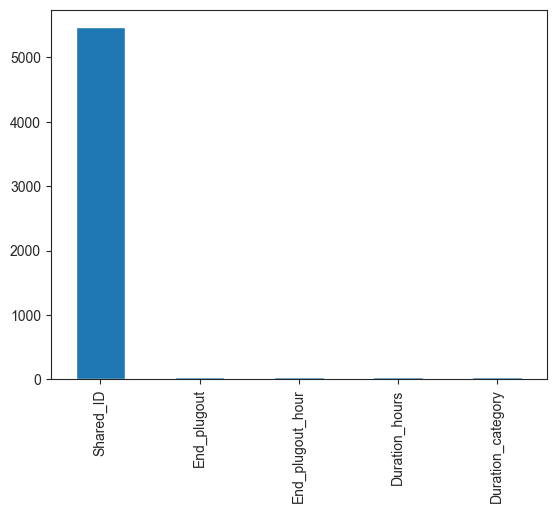

In [6]:
# visualize missing data
import seaborn as sns

sns.set_style('ticks')
missing = df1.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(ascending=False, inplace=True)
missing.plot.bar()

print(missing)
print()
print('the number of features with missing data: %i' % missing.count())

In [7]:
df1['Shared_ID'].unique()

array([nan, 'Shared-7', 'Shared-12', 'Shared-5', 'Shared-6', 'Shared-11',
       'Shared-4', 'Shared-2', 'Shared-3', 'Shared-8', 'Shared-1',
       'Shared-10', 'Shared-9'], dtype=object)

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6878 entries, 0 to 6877
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   session_ID         6878 non-null   int64         
 1   Garage_ID          6878 non-null   object        
 2   User_ID            6878 non-null   object        
 3   User_type          6878 non-null   object        
 4   Shared_ID          1412 non-null   object        
 5   Start_plugin       6878 non-null   datetime64[ns]
 6   Start_plugin_hour  6878 non-null   int64         
 7   End_plugout        6844 non-null   datetime64[ns]
 8   End_plugout_hour   6844 non-null   float64       
 9   El_kWh             6878 non-null   float64       
 10  Duration_hours     6844 non-null   float64       
 11  month_plugin       6878 non-null   object        
 12  weekdays_plugin    6878 non-null   object        
 13  Plugin_category    6878 non-null   object        
 14  Duration

In [9]:
# handling missing Shared_IDs
df1['Shared_ID'].fillna('Not_Shared', inplace=True)

/var/folders/18/8clc2py90l78rfr41n28mwfh0000gq/T/ipykernel_66112/48301390.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['Shared_ID'].fillna('Not_Shared', inplace=True)


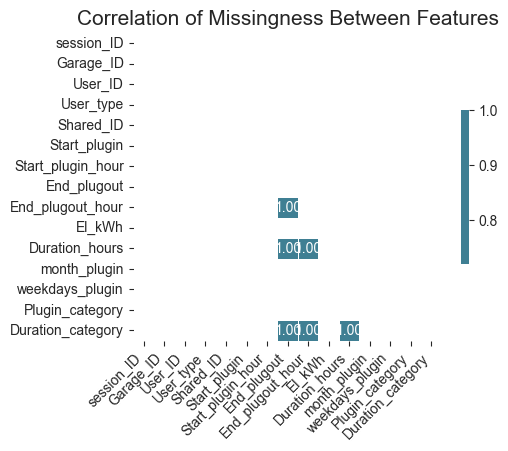

In [10]:
# correlation of missingness
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

missing_corr = df1.isna().corr()

mask = np.triu(np.ones_like(missing_corr, dtype=bool))
cmap = sns.diverging_palette(20, 220, n=200, as_cmap=True)

plt.figure(figsize=(5, 4))

sns.heatmap(missing_corr, 
            mask=mask, 
            cmap=cmap, 
            vmax=.8, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5}, 
            annot=True,
            fmt=".2f")

plt.title('Correlation of Missingness Between Features', size=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

In [11]:
# overlapping missing values
missing_end_plugout = df1[df1['End_plugout'].isna()]
print(missing_end_plugout[['End_plugout_hour', 'Duration_hours', 'Duration_category']].isna().sum())

End_plugout_hour     34
Duration_hours       34
Duration_category    34
dtype: int64


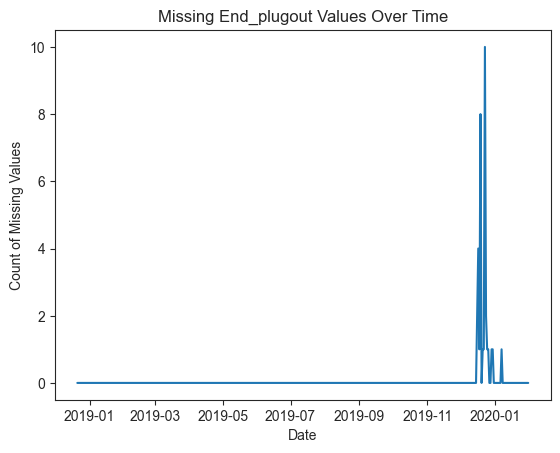

In [12]:
# temporal patterns
df1['missing_End_plugout'] = df1['End_plugout'].isna()
df1.groupby(df1['Start_plugin'].dt.date)['missing_End_plugout'].sum().plot(kind='line')
plt.title('Missing End_plugout Values Over Time')
plt.xlabel('Date')
plt.ylabel('Count of Missing Values')
plt.show()


In [13]:
# user behavior
users_with_missing = df1[df1['End_plugout'].isna()]['User_ID'].unique()
df1[df1['User_ID'].isin(users_with_missing)].groupby('User_ID').size()

User_ID
AdA6-1      156
AsO4-2      138
AsO8-3       36
Bl2-1       278
Bl2-2       319
Bl2-3       169
Bl2-5       639
Bl2-8       149
MS22-1       59
NR1-1        89
Ris-1        42
Ris-2        46
SR2-3       131
Share-12    136
Share-15     29
Share-17     15
Share-32      2
UT1-1       135
UT15-2      116
UT7-1        29
UT7-2       116
dtype: int64

In [14]:
# imputing missing values 
# calculate overall average session duration
average_duration = df1['Duration_hours'].dropna().mean()

# impute missing End_plugout times
missing_indices = df1[df1['End_plugout'].isna()].index
df1.loc[missing_indices, 'End_plugout'] = df1.loc[missing_indices, 'Start_plugin'] + pd.to_timedelta(average_duration, unit='h')

End_plugout_hour     34
Duration_hours       34
Duration_category    34
dtype: int64

the number of features with missing data: 3


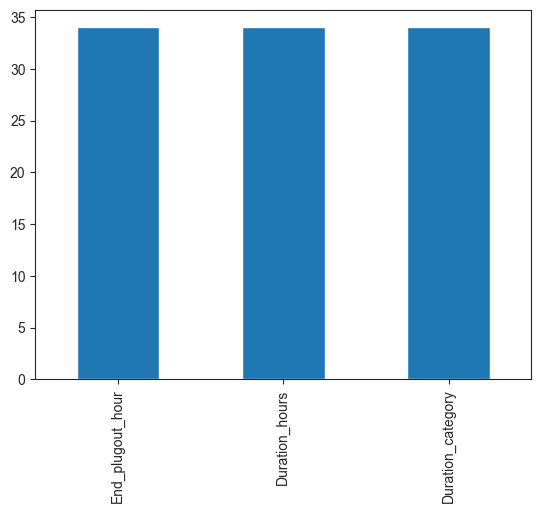

In [15]:
# visualize missing data
import seaborn as sns

sns.set_style('ticks')
missing = df1.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(ascending=False, inplace=True)
missing.plot.bar()

print(missing)
print()
print('the number of features with missing data: %i' % missing.count())

In [16]:
# handle other missing values by recalculating columns
missing_end_plugout_hour = df1['End_plugout_hour'].isna() & df1['End_plugout'].notna()
df1.loc[missing_end_plugout_hour, 'End_plugout_hour'] = df1.loc[missing_end_plugout_hour, 'End_plugout'].dt.hour

missing_duration_hours = df1['Duration_hours'].isna() & df1['End_plugout'].notna() & df1['Start_plugin'].notna()
df1.loc[missing_duration_hours, 'Duration_hours'] = (df1.loc[missing_duration_hours, 'End_plugout'] - df1.loc[missing_duration_hours, 'Start_plugin']).dt.total_seconds() / 3600

Duration_category    34
dtype: int64

the number of features with missing data: 1


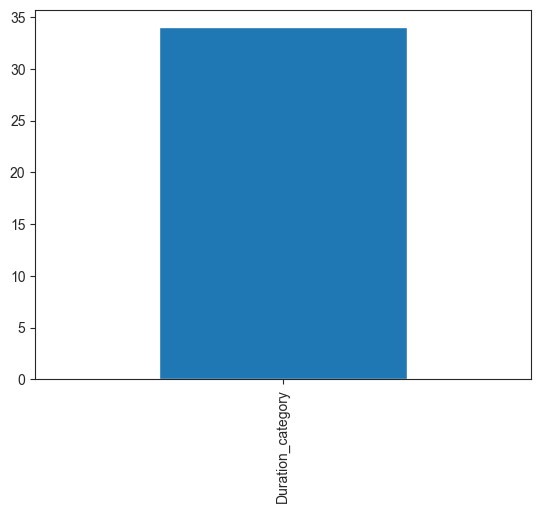

In [17]:
# visualize missing data
import seaborn as sns

sns.set_style('ticks')
missing = df1.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(ascending=False, inplace=True)
missing.plot.bar()

print(missing)
print()
print('the number of features with missing data: %i' % missing.count())

In [18]:
df1['Duration_category'].unique()

array(['Less than 3 hours', 'Between 6 and 9  hours',
       'More than 18 hours', 'Between 3 and 6 hours',
       'Between 15 and 18 hours', 'Between 12 and 15 hours',
       'Between 9 and 12 hours', nan], dtype=object)

In [19]:
import numpy as np

# conditional logic for categories
conditions = [
    (df1['Duration_hours'] <= 3),
    (df1['Duration_hours'] > 3) & (df1['Duration_hours'] <= 6),
    (df1['Duration_hours'] > 6) & (df1['Duration_hours'] <= 9),
    (df1['Duration_hours'] > 9) & (df1['Duration_hours'] <= 12),
    (df1['Duration_hours'] > 12) & (df1['Duration_hours'] <= 15),
    (df1['Duration_hours'] > 15) & (df1['Duration_hours'] <= 18),
    (df1['Duration_hours'] > 18)
]

# categories for the conditions
categories = [
    'Less than 3 hours',
    'Between 3 and 6 hours',
    'Between 6 and 9 hours',
    'Between 9 and 12 hours',
    'Between 12 and 15 hours',
    'Between 15 and 18 hours',
    'More than 18 hours'
]

# find rows where Duration_category is missing
missing_duration_category = df1['Duration_category'].isna()

# temporary column for all rows
df1['new_duration_category'] = np.select(conditions, categories, default=np.nan)

# update 'Duration_category' where it is missing
df1.loc[missing_duration_category, 'Duration_category'] = df1.loc[missing_duration_category, 'new_duration_category']

# drop the 'new_duration_category' column
df1.drop('new_duration_category', axis=1, inplace=True)

In [20]:
# final missing value check
df1.isnull().sum()

session_ID             0
Garage_ID              0
User_ID                0
User_type              0
Shared_ID              0
Start_plugin           0
Start_plugin_hour      0
End_plugout            0
End_plugout_hour       0
El_kWh                 0
Duration_hours         0
month_plugin           0
weekdays_plugin        0
Plugin_category        0
Duration_category      0
missing_End_plugout    0
dtype: int64

In [21]:
df1.head()

,session_ID,Garage_ID,User_ID,User_type,Shared_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,month_plugin,weekdays_plugin,Plugin_category,Duration_category,missing_End_plugout
0,1,AdO3,AdO3-4,Private,Not_Shared,2018-12-21 10:20:00,10,2018-12-21 10:23:00,10.0,0.30,0.050000,Dec,Friday,late morning (9-12),Less than 3 hours,False
1,2,AdO3,AdO3-4,Private,Not_Shared,2018-12-21 10:24:00,10,2018-12-21 10:32:00,10.0,0.87,0.136667,Dec,Friday,late morning (9-12),Less than 3 hours,False
2,3,AdO3,AdO3-4,Private,Not_Shared,2018-12-21 11:33:00,11,2018-12-21 19:46:00,19.0,29.87,8.216389,Dec,Friday,late morning (9-12),Between 6 and 9 hours,False
3,4,AdO3,AdO3-2,Private,Not_Shared,2018-12-22 16:15:00,16,2018-12-23 16:40:00,16.0,15.56,24.419722,Dec,Saturday,late afternoon (15-18),More than 18 hours,False
4,5,AdO3,AdO3-2,Private,Not_Shared,2018-12-24 22:03:00,22,2018-12-24 23:02:00,23.0,3.62,0.970556,Dec,Monday,late evening (21-midnight),Less than 3 hours,False


#### check for duplicates

In [22]:
duplicates = df1.duplicated()
num_duplicates = duplicates.sum()
print(f"number of duplicate rows: {num_duplicates}")

number of duplicate rows: 0


In [23]:
# inspect duplicate rows
if num_duplicates > 0:
    print(df1[duplicates])

In [24]:
df1.describe()

,session_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours
count,6878.000000,6878,6878.000000,6878,6878.000000,6878.000000,6878.000000
mean,3439.500000,2019-10-01 11:38:00.218086912,16.325240,2019-10-01 23:08:12.614637056,12.524571,12.720744,11.504440
min,1.000000,2018-12-21 10:20:00,0.000000,2018-12-21 10:23:00,0.000000,0.010000,0.003333
25%,1720.250000,2019-08-04 21:32:15,15.000000,2019-08-05 11:12:00,7.000000,5.200000,2.799444
50%,3439.500000,2019-11-02 17:53:00,17.000000,2019-11-03 11:49:00,12.000000,9.050000,10.090694
75%,5158.750000,2019-12-19 06:15:30,19.000000,2019-12-19 14:58:00,17.000000,16.090000,15.198819
max,6878.000000,2020-01-31 20:42:00,23.000000,2020-01-31 23:53:00,23.000000,80.860000,255.029444
std,1985.651908,NaN,4.363108,NaN,5.280187,11.787938,14.113150


In [25]:
# determine severity of skew

mean_value = df1['Duration_hours'].mean()
median_value = df1['Duration_hours'].median()

# calculate the difference
difference = abs(mean_value - median_value)

# calculate 20% of the mean (moderate to severe skew) or 10% of the mean (mild skew)
twenty_percent_of_mean = 0.20 * mean_value

# determine if the difference is significant
is_significant = difference > twenty_percent_of_mean

print(f"is the difference significant? {is_significant}")

is the difference significant? False


In [26]:
# percent difference between mean and median

mean_value = df1['Duration_hours'].mean()
median_value = df1['Duration_hours'].median()

# calculate the absolute difference between mean and median
absolute_difference = abs(mean_value - median_value)

# calculate the percentage difference
percentage_difference = (absolute_difference / mean_value) * 100

print(f"percentage difference between mean and median: {percentage_difference:.2f}%")


percentage difference between mean and median: 12.29%


In [27]:
# iqr relative to the median 

import pandas as pd

# calculate the 25th and 75th percentiles (Q1 and Q3)
Q1 = df1['Duration_hours'].quantile(0.25)
Q3 = df1['Duration_hours'].quantile(0.75)

# calculate the IQR
IQR = Q3 - Q1

# calculate the median
median_value = df1['Duration_hours'].median()

# calculate the IQR as a proportion of the median
IQR_proportion = IQR / median_value

print(f"iqr as a proportion of the median: {IQR_proportion:.2f}")

iqr as a proportion of the median: 1.23


some statistics of interest:
- *El_kWh*: mean: 12.72, std: 11.79, range: 0.01-80.86, 50% (median): 9.05
- *Duration_hours*: mean: 11.50, std: 14.11, range: 0.003-255.03, 50% (median): 10.09

median to mean comparison to understand skewness:
- *El_kWh*: mean: 12.72 vs median: 9.05, interpretation: suggests skewness. the mean is more affected by outliers and extreme values. the difference suggests the mean is being pulled away from the median and also that the distribution is significantly skewed (a difference beyond 20%). percent difference: 28.86%.
- *Duration_hours*: mean: 11.50 vs median: 10.09, interpretation: suggests skewness. the mean is more affected by outliers and extreme values. the difference suggests the mean is being pulled away from the median and also that there is a mild skew (a difference within 10%). percent difference: 12.29%.

interpreting percentiles:
- *El_kWh*: spread (IQR): (25%) 5.20 - (75%) 16.09, distribution shape: the data piles up more quickly on the lower end and spreads out toward the higher end, tail length and outliers (75% v max): the difference suggests the presence of outliers. the iqr as a proportion of the median: 1.20. the ratio is slightly abouve 1, indicating the iqr is spread out over a wide range.
- *Duration_hours*: spread (IQR): (25%) 2.80 - (75%) 15.20, distribution shape: the data piles up more quickly on the lower end and spreads out toward the higher end, tail length and outliers (75% v max):  the difference suggests the presence of outliers. the iqr as a proportion of the median: 1.23. the ratio is slightly abouve 1, indicating the iqr is spread out over a wide range.

other notes:
- *El_kWh* and *Duration_hours* have high standard deviations suggesting values are spread out over a wide range, indicating variability in charging session lengths and energy consumption.
- the wide range in both *El_kWh* and *Duration_hours* might indicate the presence of outliers. a **box plot** can help visualize outliers. 
- the mean vs median comparison shows both distributions are right-skewed (positive skew)
- depending on the machine learning models to be used, it may be necessary to normalize or standardize data for alorithms that are sensitive to the scale of data. in addition, data transformation may be necessary given the presence of skewness before applying machine learning models.
- other visualizations: **histograms**, **density plots**, **scatter plots**, and **time series plots** for temporal patterns.

In [28]:
# # save the DataFrame to a CSV file
# df1.to_csv('cleaned_ev_dataset.csv', index=False)

### eda

In [29]:
# export path
export_vis = 'vis/'

#### pair plots
explore the relationship between two variables to identify patterns, trends, and potential correlations.

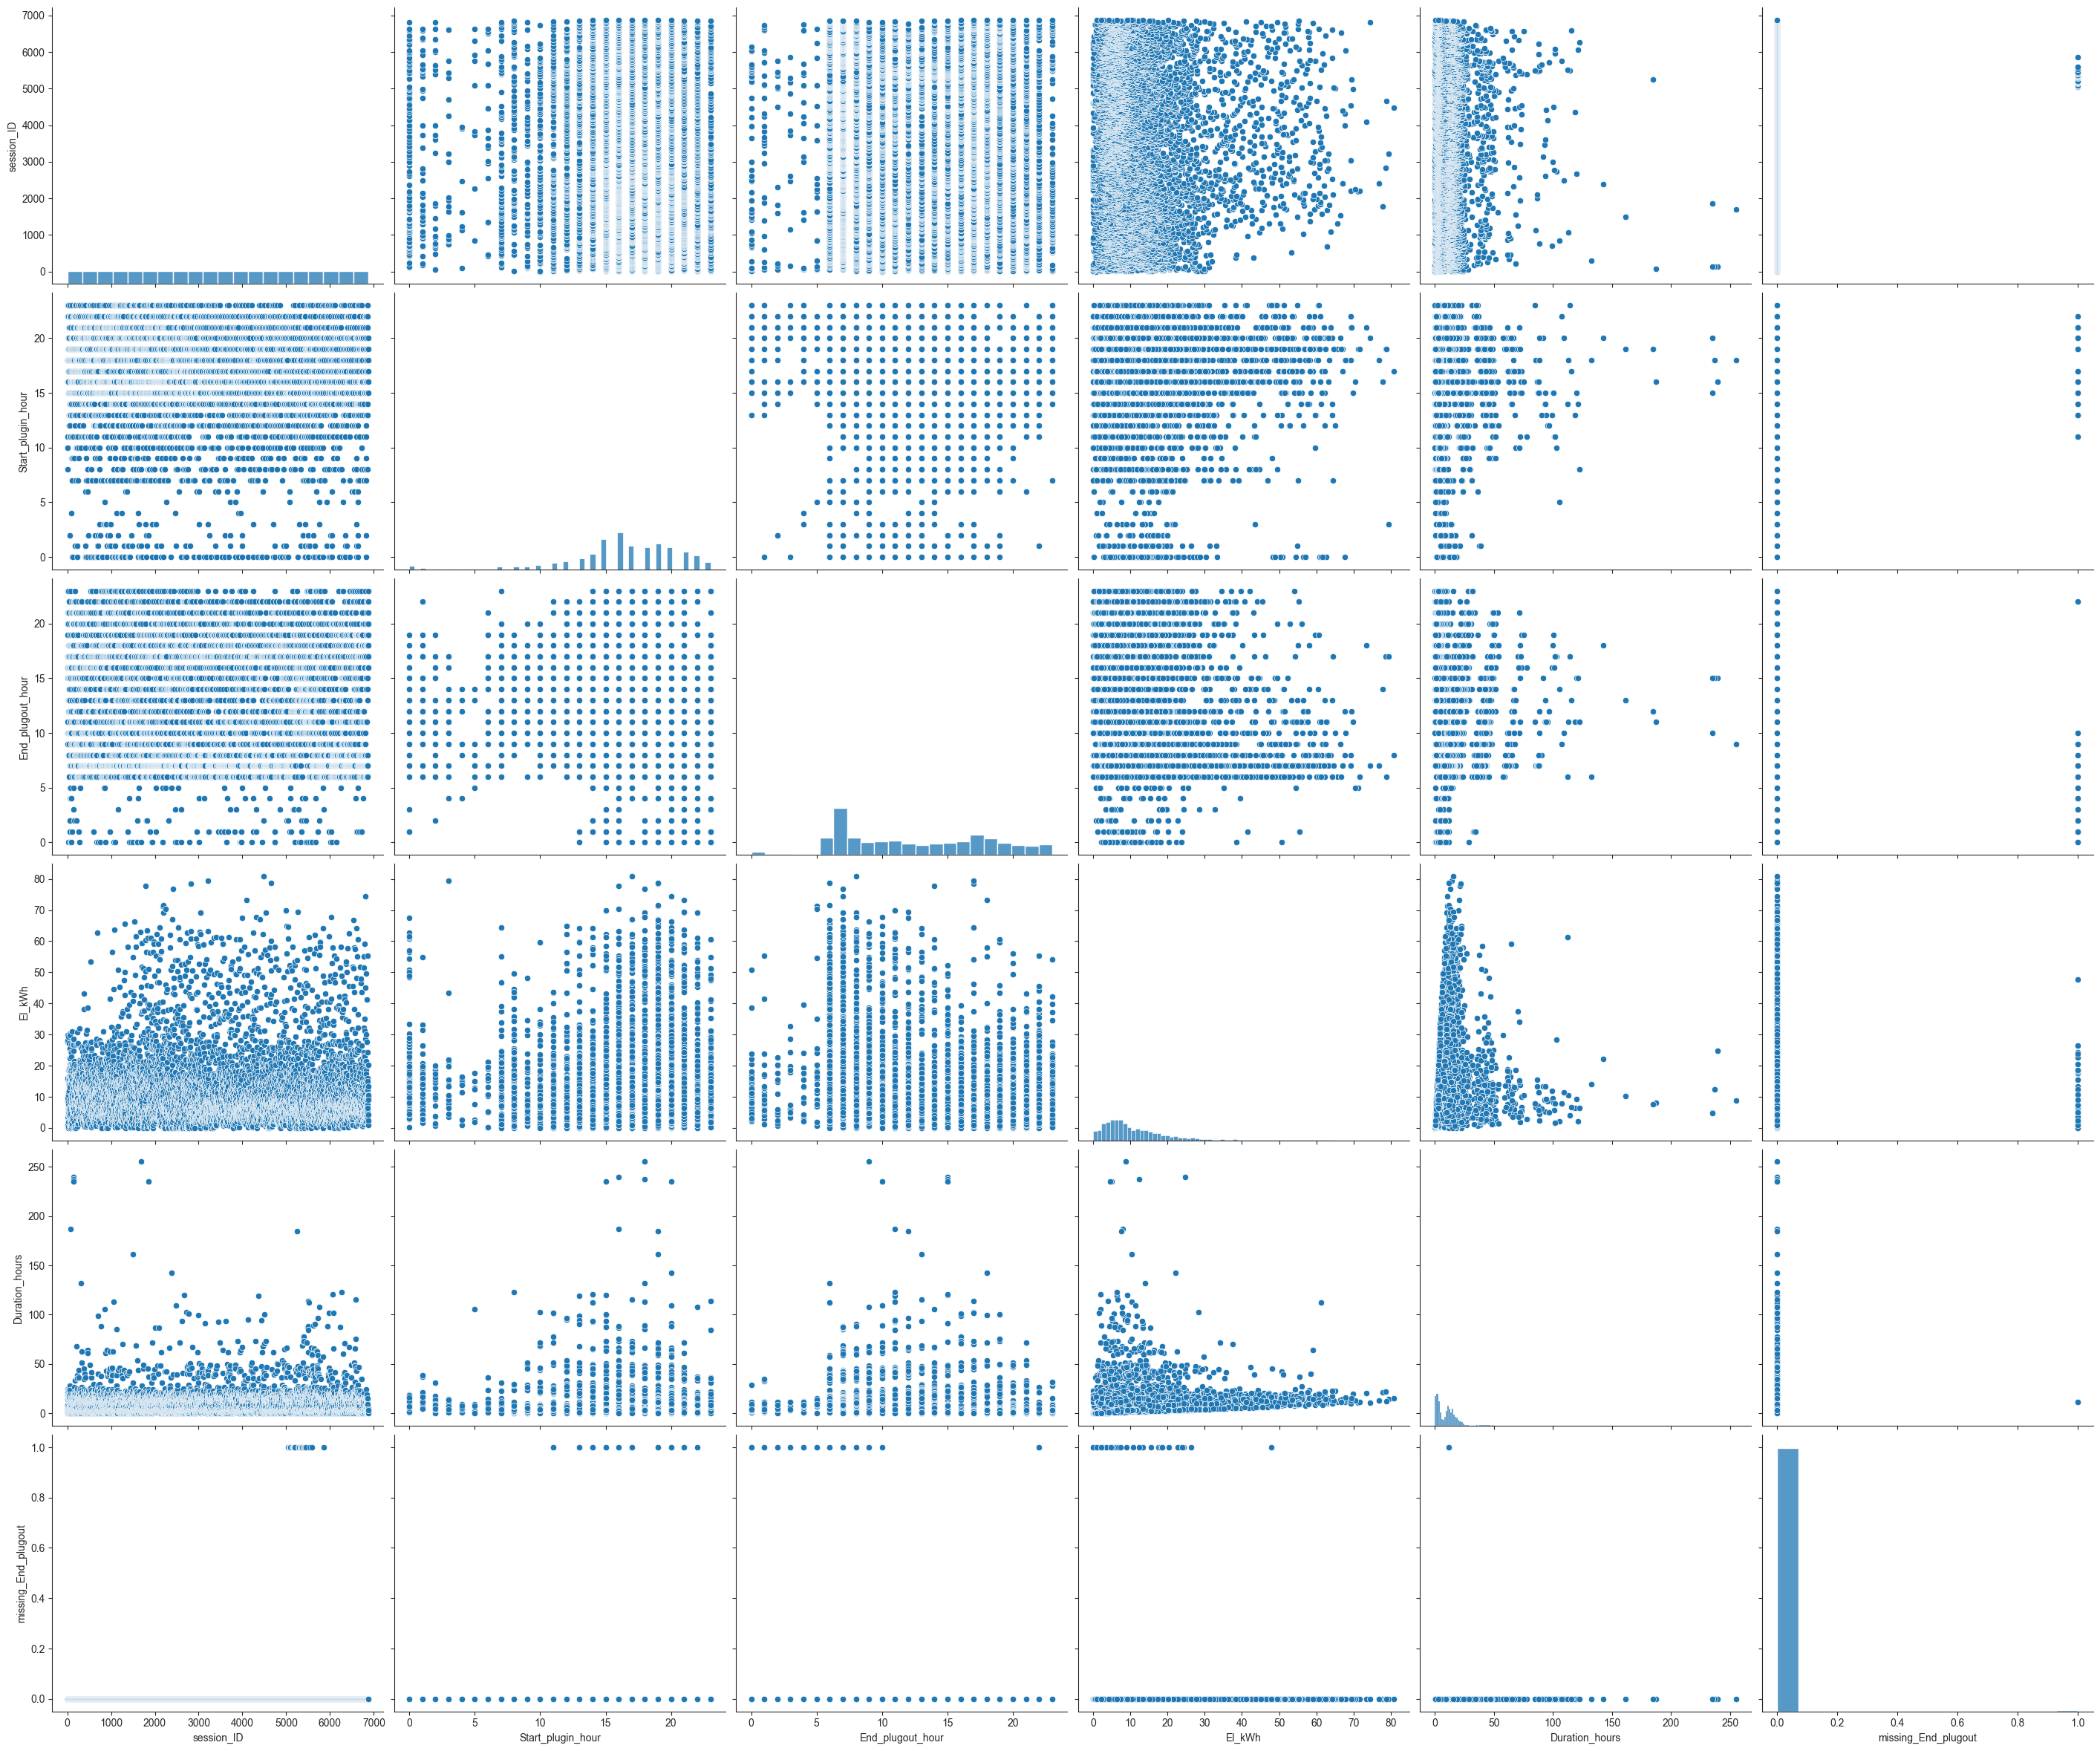

In [30]:
# create pairplot
pairplot = sns.pairplot(df1, height=4, aspect=1.2)

# save pairplot with higher resolution
pairplot.savefig(f"{export_vis}/pairplot.png", dpi=300)

plt.show()

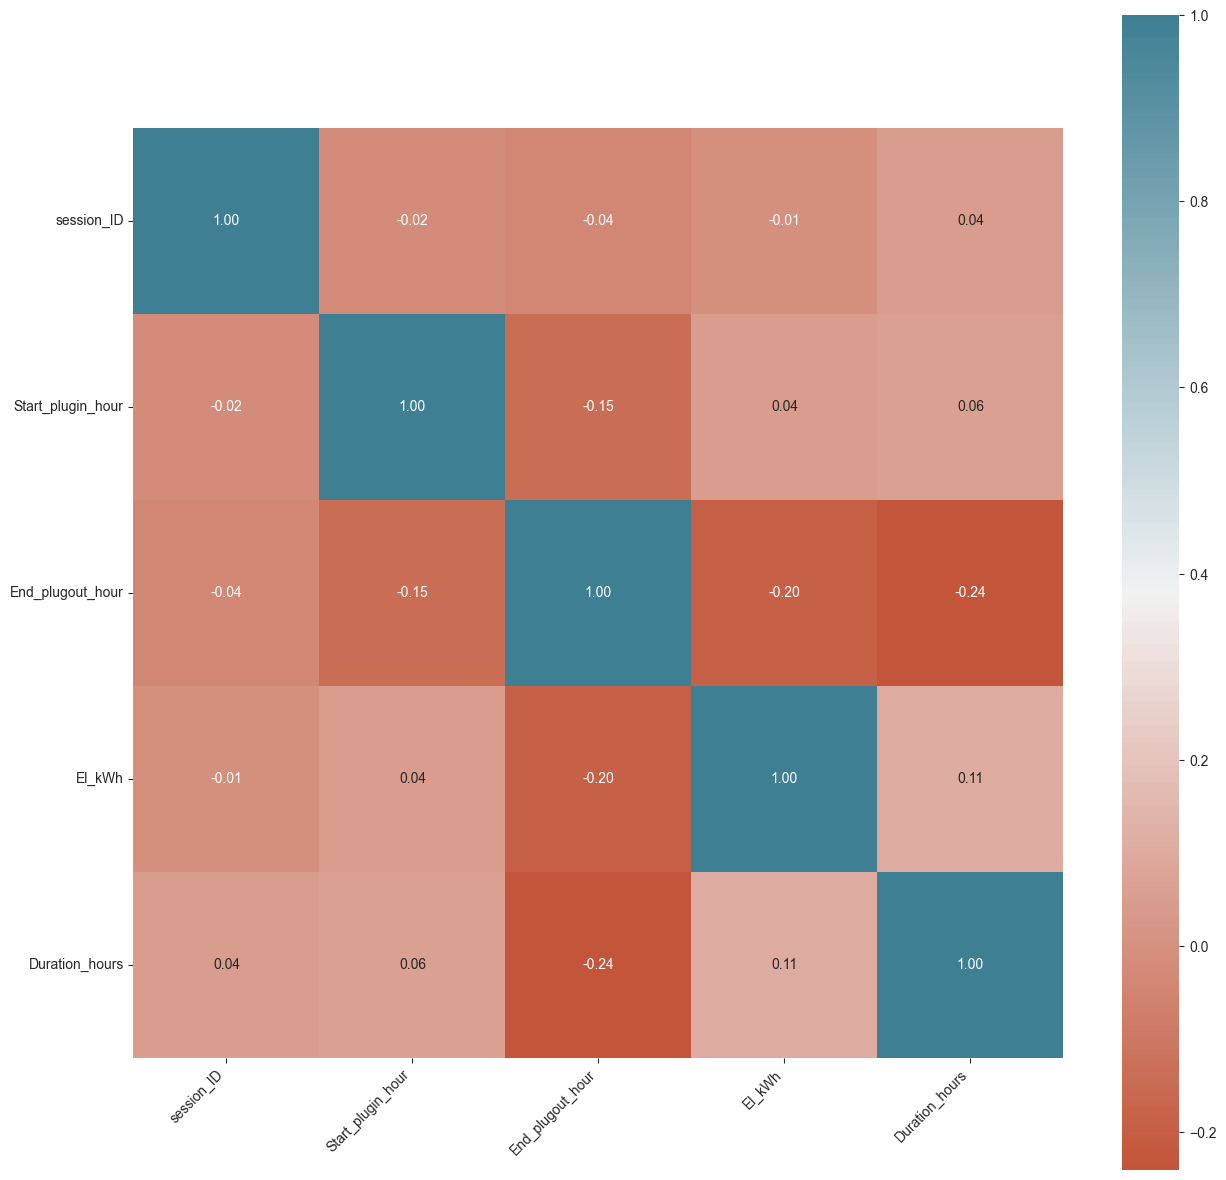

In [31]:
# select only the numeric columns for the correlation matrix
numeric_df = df1.select_dtypes(include=[np.number])

# calculate the correlation matrix on the numeric-only df
correlation_matrix = numeric_df.corr()

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap=sns.diverging_palette(20, 220, n=200), 
            square=True
            )

# rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)  # Keep the y-axis labels horizontal

plt.savefig(f"{export_vis}/correlation_heatmap.png")

plt.show()

the pairplot is an initial visualization tool that can point to areas of interest for more detailed statistical analysis. it's a good starting point to identify variables of interest, suggest hypotheses, and guide further, more focused exploration.

**scatter plots**
- there doesn't appear to be strong linear relationships in many of the scatter plots, as points are widely dispersed and do not follow a clear linear pattern. this implies that linear models may not be the best fit for predicting outocmes based on these variables. it may be necessary to perform feature engineering or transformation. `El_kWh` vs `Duration_hours` plots show dense clustering of data points at the lower end of the scales, indicating that for many pairs of variables, high values are less common. this is consistent with the right-skew in both histograms. the energy consumed and the duration for most charging sessions tend to be on the lower end and fewer sessions have very long durations or very high energy consumption. ***MORE NOTES ON RELATIONSHIP. a further investigation with a correlation coefficient or scatter plot with a regression line will be performed to help clarify the strength and nature of this relationship.
- the vertical or horizontal lines in some of the scatter plots, like `Start_plugin_hour` and `End_plugout_hour` are due to the categorical nature of these variables with a discrete number of values corresponding to the 24 hours of the day.`session_ID` and `missing_End_plugout` are categorical as well and explain their scatterplots.

**histograms on the diagonal**
most of the distributions are heavily right-skewed, as indicated by the concentration of data on the left and long tails to the right. 

**next steps**
- most of the plots appear diffuse, suggesting varying degrees of correlation or non-linear relationships. the relationship between `El_kWh` vs `Duration_hours` will be further investigated. 
- to proceed with modeling, transformations will be performed due to the presence of skewness. in addition, outliers will be further investigated to determine whether they are errors or exceptional cases.
- feature engineering might involve creating new variables that capture the interactions between `Duration_hours` and `El_kWh`. 
- explore non-linear regression models or polynomial regression

##### further investigation of relationship between `El_kWh` and `Duration_hours`

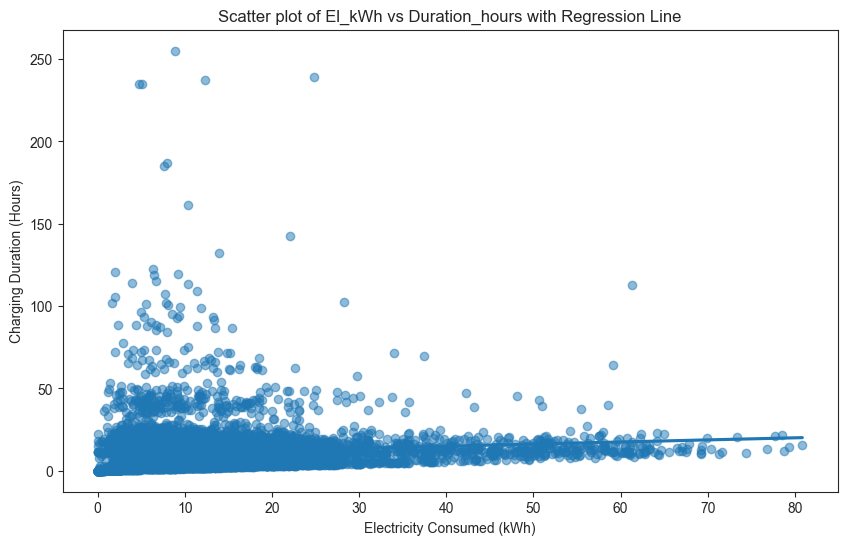

In [32]:
# create a scatter plot with a regression line
plt.figure(figsize=(10, 6))

scatter_plot = sns.regplot(x='El_kWh', y='Duration_hours', data=df1, ci=None, scatter_kws={'alpha':0.5})

plt.title('Scatter plot of El_kWh vs Duration_hours with Regression Line')
plt.xlabel('Electricity Consumed (kWh)')
plt.ylabel('Charging Duration (Hours)')

# save the figure
plt.savefig(f'{export_vis}/el_kwh_vs_duration_hours_regression.png')

plt.show()

In [33]:
# calculate the pearson correlation coefficient
correlation_coefficient = df1['El_kWh'].corr(df1['Duration_hours'])
print(f"the pearson correlation coefficient between El_kWh and Duration_hours: {correlation_coefficient:.2f}")

the pearson correlation coefficient between El_kWh and Duration_hours: 0.11


*pearson correlation coefficient*\
the pearson correlation coefficient between El_kWh and Duration_hours suggests a very weak positive linear relationship. 

*density of data points*\
the plot shows a high density of data points towards the lower end of both axes, suggesting that most charging sessions consumed a smaller amout of electricity and had shorter durations.

*outliers*\
there are some outliers present, especially in the charging duration, which could be due to the rare occasion that a vehicle is plugged in for an extended period.

*trend and correlation*\
the regression line is relatively flat, reinforcing the weak correlation between the elecricity consumed and the charging duration.

*variability*\
there is a lot of variability between 0-30kWh that begins to decrease toward higher levels of electricity consumed, which could indicate that the charging behavior becomes more consistent at higher levels of energy consumption. this variability could be due to battery charging capacities and charging speeds.

*regression line*\
the regression line suggests that the average increase in charging duration with increased electricity consumption is very slight.

#### histograms and density plots
understand the distribution of variables of interest and identify skewness, peaks, and the spread of data.

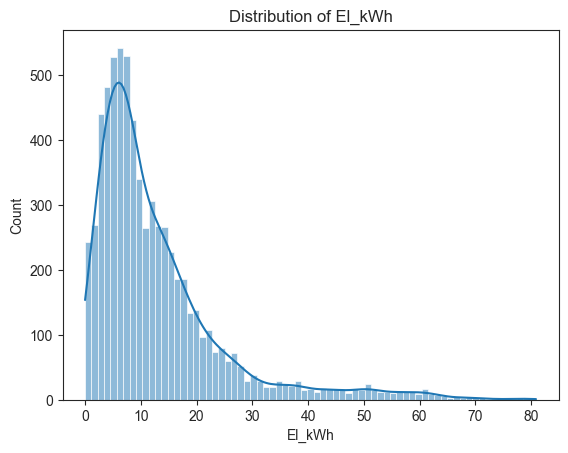

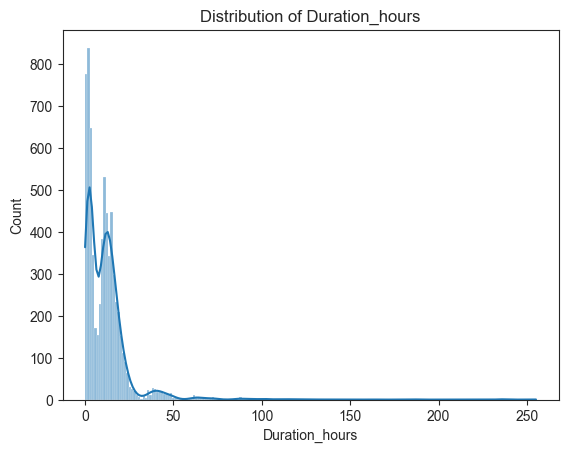

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# El_kWh
sns.histplot(df1['El_kWh'], kde=True)
plt.title('Distribution of El_kWh')
plt.savefig(f"{export_vis}/distribution_of_el_kwh.png")
plt.show()

# Duration_hours
sns.histplot(df1['Duration_hours'], kde=True)
plt.title('Distribution of Duration_hours')
plt.savefig(f"{export_vis}/distribution_of_duration_hours.png")
plt.show()

*distribution of El_kWh*:\
right-skewed (positively skewed) — most of the data points are clustered towards the left side of the histogram, or the lower values, with a tail that extends to the right, or the higher values. the mode (peak of the distribution) is lower than the mean (average). most charging sessions consume a smaller amount of electricity. the long tail towards the right suggests there are outliers or sessions with unusually high electricity consumption

*distribution of Duration_hours*:\
right-skewed (positively skewed) — most of the charging sessions are shorter charging sessions. the distribution has a clear initial peak near the lower end followed by a second peak. the second peak might be associated with longer, overnight charging sessions. the presence of a long tail could be due tooutliers or instances where EVs were charged for an exceptionally long time. the bulk of the data is concentrated near the start of the distribution, showing most sessions are shorter.

#### box plots
visualize the quartiles of the data and identify outliers. they show the median, iqr, and potential outliers.

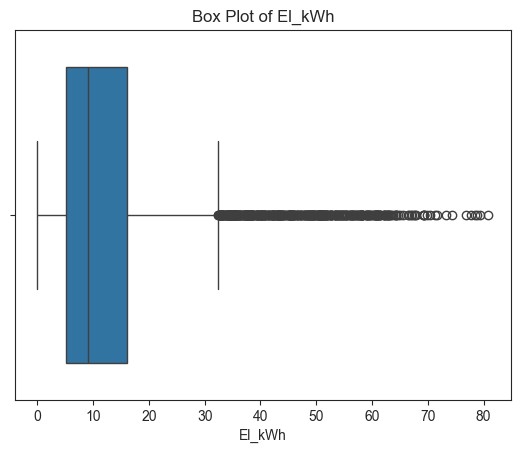

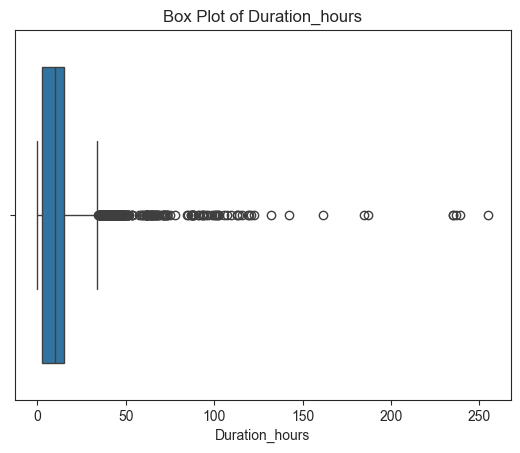

In [35]:
# El_kWh
sns.boxplot(x=df1['El_kWh'])
plt.title('Box Plot of El_kWh')
plt.savefig(f"{export_vis}/box_plot_of_el_kwh.png")
plt.show()

# Duration_hours
sns.boxplot(x=df1['Duration_hours'])
plt.title('Box Plot of Duration_hours')
plt.savefig(f"{export_vis}/box_plot_of_duration_hours.png")
plt.show()

*box plot for electricity consumed (kWh)*
- central tendency and spread\
most of the data falls within the lower range of electricity consumed, which is consistent with what was seen in the descriptive statistics and distribution. 
- skewness\
many outliers are present on the right-hand side of the plot, indicating right-skewness. 
- outliers\
there are a number of charging sessions with unusually high electricity consumption. there are quite a few outliers present. further investigation is needed to understand them.

*box plot for duration hours*
- central tendency and spread\
the majority of the data falls within the lower range of the duration hours, suggesting that most sessions are of shorter duration. 
- skewness\
the data is right-skewed, reflecting that there are charging sessions that last significantly longer than the majority.
- outliers\
there are many outliers present in the data. further investigation is needed to understand the context of the outliers (whether they're due to variations in charging behavior, technology, or due to error, or other factors) in order to handle them properly prior to modeling.

In [36]:
# variability

# calculate range
range_duration = df1['Duration_hours'].max() - df1['Duration_hours'].min()
range_el_kwh = df1['El_kWh'].max() - df1['El_kWh'].min()

# calcule interquartile range (IQR)
Q1_duration = df1['Duration_hours'].quantile(0.25)
Q3_duration = df1['Duration_hours'].quantile(0.75)
IQR_duration = Q3_duration - Q1_duration

Q1_el_kwh = df1['El_kWh'].quantile(0.25)
Q3_el_kwh = df1['El_kWh'].quantile(0.75)
IQR_el_kwh = Q3_el_kwh - Q1_el_kwh

# calculate variabce
variance_duration = df1['Duration_hours'].var()
variance_el_kwh = df1['El_kWh'].var()

# calculate standard deviation
std_deviation_duration = df1['Duration_hours'].std()
std_deviation_el_kwh = df1['El_kWh'].std()

# display the results
print(f"duration hours - range: {range_duration}, iqr: {IQR_duration}, variance: {variance_duration}, standard deviation: {std_deviation_duration}")
print(f"el_kwh - range: {range_el_kwh}, iqr: {IQR_el_kwh}, variance: {variance_el_kwh}, standard deviation: {std_deviation_el_kwh}")

duration hours - range: 255.026111067, iqr: 12.39937500025, variance: 199.18100107403163, standard deviation: 14.11314993451255
el_kwh - range: 80.85, iqr: 10.89, variance: 138.95548931055103, standard deviation: 11.787938297707154


#### time series plots
reveal temporal patterns to identify cyclic trends, seasonal variations, or anomalies over time.

In [37]:
df1['Start_plugin'] = pd.to_datetime(df1['Start_plugin']).sort_values()
df1.set_index('Start_plugin', inplace=True)

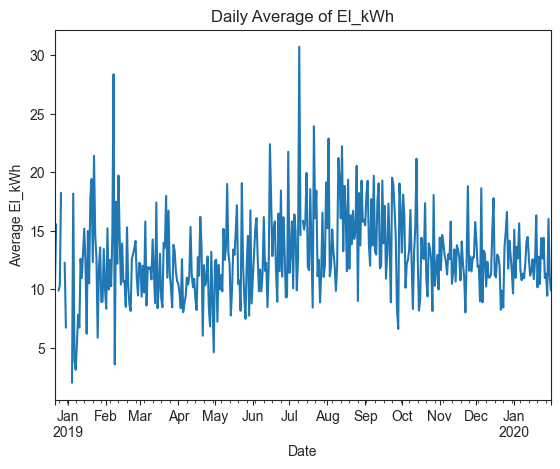

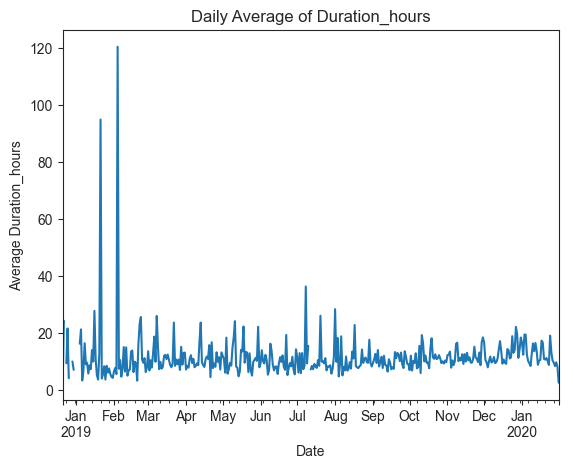

In [38]:
# daily average

# El_kWh
df1['El_kWh'].resample('D').mean().plot(title='Daily Average of El_kWh')
plt.ylabel('Average El_kWh')
plt.xlabel('Date')
plt.savefig(f"{export_vis}/daily_avg_el_kwh.png")
plt.show()

# Duration_hours
df1['Duration_hours'].resample('D').mean().plot(title='Daily Average of Duration_hours')
plt.ylabel('Average Duration_hours')
plt.xlabel('Date')
# plt.savefig(f"{export_vis}/daily_avg_distribution_hours.png")
plt.show()

#### electric consumption (kWh)

*trends*:
- january to february - there is a decline in the average electricity consumed after a peak in january. this could be due to colder weather impacting increased energy consumption, increased travel after the holiday season, or a combination of both. 
- may through august - this period is relatively stable with a slight upward trend. this could be due to vacation periods when people might use their evs for longer trips or the longer daylight hours could encourage more travel.
- september through november - there's a noticable decline in this period. this could be the impact of transitioning weather or less recreational travel.

*seasonality*:
there are some visible spikes, but without a clear seasonal pattern. further analysis of the series, such as decomposition, may reveal seasonal trends. seasonality is challenging to identify in a dataset that spans one year. it is easier to detect over multiple cycles because repeated patterns become more apparent.

*volatility*:
the plot shows variability in the daily averages with some days having significantlly higher consumption than others. this could be due to special events.

*anomalies*:
the spikes in the plot suggest days with unusually high electricity consumption. these could be due to special events or could indicate data errors. 


#### charge duration (hours)

*trends*:
there doesn't seem to be a clear trend over the year. the mean value seems fairly  consistent over time, suggesting stable average charging times. 

*seasonality*:
there are no obvious repeating patterns that suggest a strong seasonal effect. again, without additional years of data, it is difficult to make a definitive statement regarding seasonality.

*volatility*:
the data shows considerable volatility, with a few extreme spikes, especially noticeable at the beginning of the year.

*anomalies*:
the very large spikes early in the year could be anomolies or outliers. they may need to be investigated to determine their cause. they might represent data errors, special events, or other non-representative occurrences that could distort the analysis. 

#### next steps 
1. investigate the cause of extreme values. determine whether they are data errors, anomolies, or legitimate values that can be explained by factors such as public holidays, special events, or changes in charging infrastructure.
2. smooth the data to better visualize underlying trends or patterns (moving average, or other smoothing techniques). 
3. decompose the time series to separate the time series into trend, seasonal, and residual components.
4. examine autocorrelation to understand the dependency of data points on previous values, which guide the selection of appropriate time series forecasting models using the autocorrelation function (acf) and partial autocorrelation function (pacf).
5. introduce other data to see if there are correlations with other factors such as weather conditions, days of the week, economic activity, holidays, or other external events. 
6. statistical tests for outliers to confirm the anomalies and hypothesis testing to identify any systematic differences between different times of the year or other categorical factors that might be available in the data. 
7. statistical tests for seasonality, like the seasonal decomposition of time series (stl or x-13arima-seats), to hel identify and quantify seasonal effects or a machine learning model, such as facebook's prophet that can handle seasonal patterns within a single year of data.
8. statistical tests for trend.

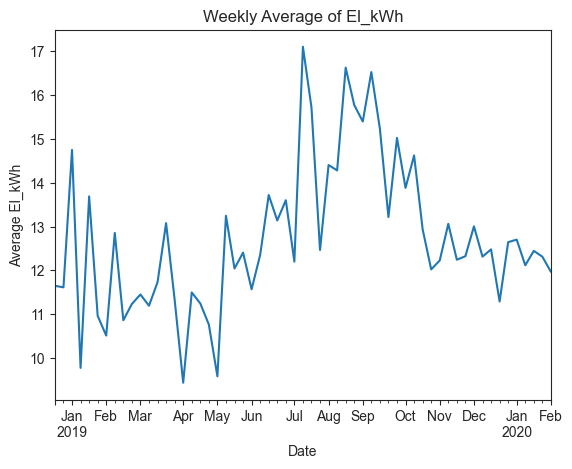

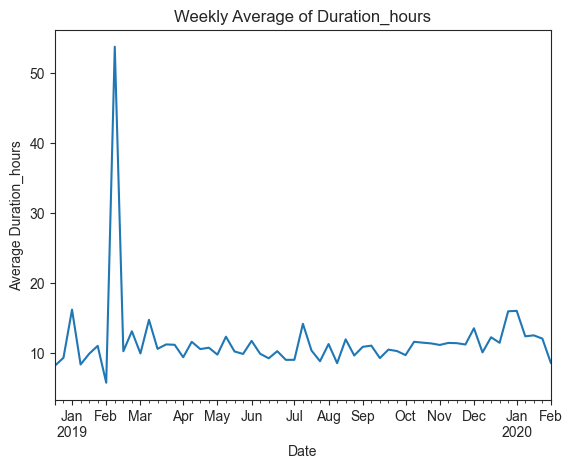

In [39]:
# weekly average

# El_kWh
df1['El_kWh'].resample('W').mean().plot(title='Weekly Average of El_kWh')
plt.ylabel('Average El_kWh')
plt.xlabel('Date')
plt.savefig(f"{export_vis}/weekly_avg_el_kwh.png")
plt.show()

# Duration_hours
df1['Duration_hours'].resample('W').mean().plot(title='Weekly Average of Duration_hours')
plt.ylabel('Average Duration_hours')
plt.xlabel('Date')
plt.savefig(f"{export_vis}/weekly_avg_distribution_hours.png")
plt.show()

#### electric consumption (kWh)

*trends*:
- there is a notable increase in average consumption around the middle of the year, which could be attributed to factors such as weather leading to an increase in travel.
- towards the end of the year, there is a downward trend, possibly linked to weather becoming colder, which may dissuade travel, and could also be due to behavior changes due to the holiday season.

*seasonality*:
the data does not suggest clear seasonality due to a limited timeframe of data.

*volatility*:
the plot suggests volatility in electric consumption, with some weeks having significantly higher or lower averages than others.

*anomalies*:
there are a few spikes in the data that could represent actual events (such as holidays or behavioral changes). further investigation is needed to confirm they are part of a pattern. checking for correlations with external factors, such as weather conditions, could explain some of the changes in trends seen. aside from the spikes, there seems to be a fairly consistent range of fluctuation, suggesting that while individual weeks may vary, the overall consumption patterns are relatively stable.

#### charge duration (hours)

*trends*:
there's an initial peak in february and then a stabilizing trend. 

*seasonality*:
the data does not suggest clear seasonality, but some of the periodic spikes could indicate weekly or monthly patterns.

*volatility*:
the high spike at the beginning of the year could be a period of high volatility

*anomalies*:
the extreme value at the start of the time series could be an outlier or data entry error.

/var/folders/18/8clc2py90l78rfr41n28mwfh0000gq/T/ipykernel_66112/3096618832.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df1['El_kWh'].resample('M').mean().plot(title='Monthly Average of El_kWh')


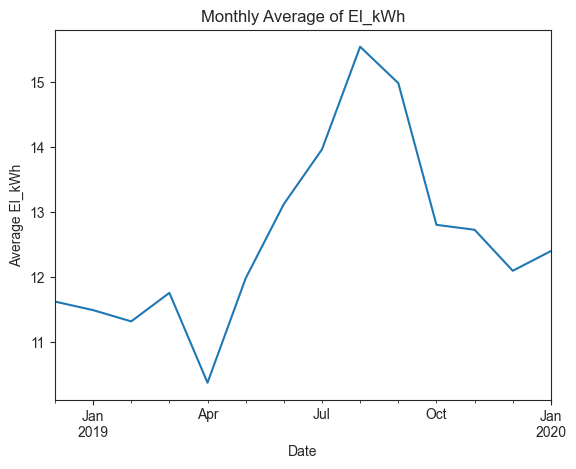

/var/folders/18/8clc2py90l78rfr41n28mwfh0000gq/T/ipykernel_66112/3096618832.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df1['Duration_hours'].resample('M').mean().plot(title='Monthly Average of Duration_hours')


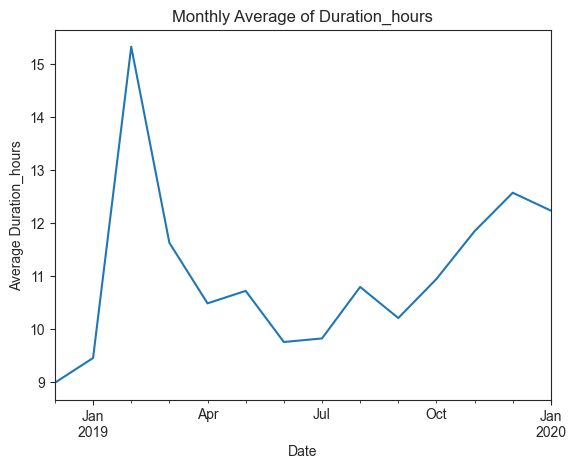

In [40]:
# monthly average

# El_kWh
df1['El_kWh'].resample('M').mean().plot(title='Monthly Average of El_kWh')
plt.ylabel('Average El_kWh')
plt.xlabel('Date')
plt.savefig(f"{export_vis}/monthly_avg_el_kwh.png")
plt.show()

# Duration_hours
df1['Duration_hours'].resample('M').mean().plot(title='Monthly Average of Duration_hours')
plt.ylabel('Average Duration_hours')
plt.xlabel('Date')
plt.savefig(f"{export_vis}/monthly_avg_distribution_hours.png")
plt.show()

#### electric consumption (kWh)

*trends*:
there's an upward trend starting in april until around july followed by a downward trend, suggesting seasonal influences or changes in user behavior.

*seasonality*:
the peak in july might suggest increased electricity consumption, potentially due to factors such as summer travel or more recreational use during the summer months. after july, there is a noticable decline, which could be due to a variety of factors including end of vacation periods, or possibly weather-related.

*volatility*:
the changes from month to moth are relatively gradual compared to daily or weekly data, indicating less volatility on a monthly scale.

*anomalies*:
the peak in july stands out, which may warrant further exploration to understand whether this is an anomaly or a pattern that could be expected to repeat annually.

#### charge duration (hours)

*trends*:
there is a significant peak in january, followed by a drop and then a general increasing trend towards the middle of the year, which slightly dips and rises again towards the end.

*seasonality*:
the spike in january and the general trend towards increasing duration mid-year could imply seasonal behavior, potentually due to extreme cold weather in january and then increase in travel or usage during summer months.

*volatility*:
the plot demonstrates that the variability in charging duration is less extreme on a monthly basis compared to the daily averages. however, the initial spike suggests a period of high variability, which then stabilizes somewhat throughout the year.

*anomalies*:
the january peak is quite pronounced and warrants further investigation to understand whether it was caused by unique events or conditions that may not recur annually.

# weather data

In [41]:
# load dataset 7
df7_path = 'data/7 norway trondheim exact location weather.csv'
df7 = pd.read_csv(df7_path, delimiter=',')

In [42]:
df7.head()

,Unnamed: 0,clouds,datetime,dewpt,dhi,dni,ghi,max_dhi,max_dni,max_ghi,...,solar_rad,t_dhi,t_dni,t_ghi,t_solar_rad,temp,ts,wind_dir,wind_gust_spd,wind_spd
0,0,66,2018-12-01,-1.7,5,40,6,34,288,48,...,2,127,966,144,52,7.4,1543618800,187,12.8,5.5
1,1,64,2018-12-02,-2.8,5,38,6,33,281,46,...,5,123,923,135,126,5.4,1543705200,177,10.8,3.6
2,2,100,2018-12-03,-0.7,5,37,5,33,273,44,...,1,119,881,128,21,2.4,1543791600,142,4.8,1.5
3,3,93,2018-12-04,-0.5,5,35,5,32,266,42,...,1,115,842,121,22,0.8,1543878000,234,12.8,3.9
4,4,87,2018-12-05,-1.9,5,34,5,32,260,41,...,2,111,804,114,39,-0.4,1543964400,206,13.6,3.7


In [43]:
df7.columns

Index(['Unnamed: 0', 'clouds', 'datetime', 'dewpt', 'dhi', 'dni', 'ghi',
       'max_dhi', 'max_dni', 'max_ghi', 'max_temp', 'max_temp_ts', 'max_uv',
       'max_wind_dir', 'max_wind_spd', 'max_wind_spd_ts', 'min_temp',
       'min_temp_ts', 'precip', 'precip_gpm', 'pres', 'revision_status', 'rh',
       'slp', 'snow', 'snow_depth', 'solar_rad', 't_dhi', 't_dni', 't_ghi',
       't_solar_rad', 'temp', 'ts', 'wind_dir', 'wind_gust_spd', 'wind_spd'],
      dtype='object')

In [44]:
df7.describe()

,Unnamed: 0,clouds,dewpt,dhi,dni,ghi,max_dhi,max_dni,max_ghi,max_temp,...,solar_rad,t_dhi,t_dni,t_ghi,t_solar_rad,temp,ts,wind_dir,wind_gust_spd,wind_spd
count,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,...,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,4.270000e+02,427.000000,427.000000,427.000000
mean,156.971897,74.662763,1.039578,29.702576,248.644028,128.379391,73.264637,605.053864,358.681499,8.902108,...,69.618267,713.107728,5967.147541,3080.974239,1670.519906,5.175644,1.562020e+09,180.925059,9.618267,2.612646
std,113.713561,25.635374,6.338840,22.245811,184.686881,123.080478,31.444455,246.667611,278.598036,7.952994,...,80.919493,533.099774,4431.394246,2953.188730,1942.385472,6.996566,1.066232e+07,52.554590,4.688022,1.156338
min,0.000000,0.000000,-13.100000,3.000000,23.000000,3.000000,26.000000,201.000000,28.000000,-8.100000,...,0.000000,81.000000,547.000000,70.000000,7.000000,-11.700000,1.543619e+09,43.000000,2.400000,1.000000
25%,43.500000,65.000000,-3.150000,7.000000,58.000000,10.000000,40.000000,352.500000,67.500000,3.200000,...,3.000000,172.000000,1399.000000,238.000000,81.000000,0.450000,1.552820e+09,144.000000,6.000000,1.800000
50%,150.000000,84.000000,0.300000,26.000000,232.000000,86.000000,80.000000,696.000000,323.000000,7.500000,...,36.000000,633.000000,5579.000000,2066.000000,874.000000,4.100000,1.562018e+09,185.000000,8.400000,2.300000
75%,256.500000,93.500000,6.100000,51.500000,431.000000,248.000000,105.000000,839.500000,647.500000,14.450000,...,113.000000,1237.000000,10343.500000,5945.500000,2715.500000,10.550000,1.571220e+09,219.500000,12.400000,3.100000
max,363.000000,100.000000,17.200000,65.000000,533.000000,339.000000,111.000000,869.000000,769.000000,31.900000,...,322.000000,1556.000000,12786.000000,8133.000000,7730.000000,26.600000,1.580425e+09,309.000000,28.400000,7.200000


### preprocess data

In [45]:
# drop unnamed column
df7.drop('Unnamed: 0', axis=1, inplace=True)

In [46]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427 entries, 0 to 426
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   clouds           427 non-null    int64  
 1   datetime         427 non-null    object 
 2   dewpt            427 non-null    float64
 3   dhi              427 non-null    int64  
 4   dni              427 non-null    int64  
 5   ghi              427 non-null    int64  
 6   max_dhi          427 non-null    int64  
 7   max_dni          427 non-null    int64  
 8   max_ghi          427 non-null    int64  
 9   max_temp         427 non-null    float64
 10  max_temp_ts      427 non-null    int64  
 11  max_uv           427 non-null    float64
 12  max_wind_dir     427 non-null    int64  
 13  max_wind_spd     427 non-null    float64
 14  max_wind_spd_ts  427 non-null    int64  
 15  min_temp         427 non-null    float64
 16  min_temp_ts      427 non-null    int64  
 17  precip          

#### inspect missing data

snow_depth    427
dtype: int64

the number of features with missing data: 1


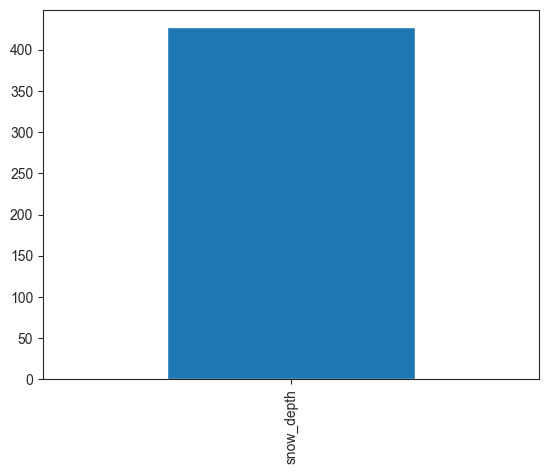

In [47]:
# visualize missing data
sns.set_style('ticks')
missing = df7.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(ascending=False, inplace=True)
missing.plot.bar()

print(missing)
print()
print('the number of features with missing data: %i' % missing.count())

In [48]:
df7 = df7.drop('snow_depth', axis=1)

In [49]:
# final missing value check
df7.isnull().sum()

clouds             0
datetime           0
dewpt              0
dhi                0
dni                0
ghi                0
max_dhi            0
max_dni            0
max_ghi            0
max_temp           0
max_temp_ts        0
max_uv             0
max_wind_dir       0
max_wind_spd       0
max_wind_spd_ts    0
min_temp           0
min_temp_ts        0
precip             0
precip_gpm         0
pres               0
revision_status    0
rh                 0
slp                0
snow               0
solar_rad          0
t_dhi              0
t_dni              0
t_ghi              0
t_solar_rad        0
temp               0
ts                 0
wind_dir           0
wind_gust_spd      0
wind_spd           0
dtype: int64

In [50]:
df7.head()

,clouds,datetime,dewpt,dhi,dni,ghi,max_dhi,max_dni,max_ghi,max_temp,...,solar_rad,t_dhi,t_dni,t_ghi,t_solar_rad,temp,ts,wind_dir,wind_gust_spd,wind_spd
0,66,2018-12-01,-1.7,5,40,6,34,288,48,9.1,...,2,127,966,144,52,7.4,1543618800,187,12.8,5.5
1,64,2018-12-02,-2.8,5,38,6,33,281,46,7.3,...,5,123,923,135,126,5.4,1543705200,177,10.8,3.6
2,100,2018-12-03,-0.7,5,37,5,33,273,44,7.2,...,1,119,881,128,21,2.4,1543791600,142,4.8,1.5
3,93,2018-12-04,-0.5,5,35,5,32,266,42,2.8,...,1,115,842,121,22,0.8,1543878000,234,12.8,3.9
4,87,2018-12-05,-1.9,5,34,5,32,260,41,0.7,...,2,111,804,114,39,-0.4,1543964400,206,13.6,3.7


#### check for duplicates

In [51]:
duplicates = df7.duplicated()
num_duplicates = duplicates.sum()
print(f"number of duplicate rows: {num_duplicates}")

number of duplicate rows: 0


In [52]:
# inspect duplicate rows
if num_duplicates > 0:
    print(df7[duplicates])

In [53]:
df7.describe()

,clouds,dewpt,dhi,dni,ghi,max_dhi,max_dni,max_ghi,max_temp,max_temp_ts,...,solar_rad,t_dhi,t_dni,t_ghi,t_solar_rad,temp,ts,wind_dir,wind_gust_spd,wind_spd
count,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,4.270000e+02,...,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,4.270000e+02,427.000000,427.000000,427.000000
mean,74.662763,1.039578,29.702576,248.644028,128.379391,73.264637,605.053864,358.681499,8.902108,1.562067e+09,...,69.618267,713.107728,5967.147541,3080.974239,1670.519906,5.175644,1.562020e+09,180.925059,9.618267,2.612646
std,25.635374,6.338840,22.245811,184.686881,123.080478,31.444455,246.667611,278.598036,7.952994,1.066216e+07,...,80.919493,533.099774,4431.394246,2953.188730,1942.385472,6.996566,1.066232e+07,52.554590,4.688022,1.156338
min,0.000000,-13.100000,3.000000,23.000000,3.000000,26.000000,201.000000,28.000000,-8.100000,1.543619e+09,...,0.000000,81.000000,547.000000,70.000000,7.000000,-11.700000,1.543619e+09,43.000000,2.400000,1.000000
25%,65.000000,-3.150000,7.000000,58.000000,10.000000,40.000000,352.500000,67.500000,3.200000,1.552876e+09,...,3.000000,172.000000,1399.000000,238.000000,81.000000,0.450000,1.552820e+09,144.000000,6.000000,1.800000
50%,84.000000,0.300000,26.000000,232.000000,86.000000,80.000000,696.000000,323.000000,7.500000,1.562069e+09,...,36.000000,633.000000,5579.000000,2066.000000,874.000000,4.100000,1.562018e+09,185.000000,8.400000,2.300000
75%,93.500000,6.100000,51.500000,431.000000,248.000000,105.000000,839.500000,647.500000,14.450000,1.571270e+09,...,113.000000,1237.000000,10343.500000,5945.500000,2715.500000,10.550000,1.571220e+09,219.500000,12.400000,3.100000
max,100.000000,17.200000,65.000000,533.000000,339.000000,111.000000,869.000000,769.000000,31.900000,1.580483e+09,...,322.000000,1556.000000,12786.000000,8133.000000,7730.000000,26.600000,1.580425e+09,309.000000,28.400000,7.200000


In [54]:
# # save the DataFrame to a CSV file
# df7.to_csv('cleaned_weather_dataset.csv', index=False)

### merge datasets

In [55]:
# convert 'datetime' to datetime format
df7['datetime'] = pd.to_datetime(df7['datetime']).sort_values()

In [56]:
# set datetime as index
df7.set_index('datetime', inplace=True)

In [57]:
df1.head()

,session_ID,Garage_ID,User_ID,User_type,Shared_ID,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,month_plugin,weekdays_plugin,Plugin_category,Duration_category,missing_End_plugout
Start_plugin,,,,,,,,,,,,,,,
2018-12-21 10:20:00,1,AdO3,AdO3-4,Private,Not_Shared,10,2018-12-21 10:23:00,10.0,0.30,0.050000,Dec,Friday,late morning (9-12),Less than 3 hours,False
2018-12-21 10:24:00,2,AdO3,AdO3-4,Private,Not_Shared,10,2018-12-21 10:32:00,10.0,0.87,0.136667,Dec,Friday,late morning (9-12),Less than 3 hours,False
2018-12-21 11:33:00,3,AdO3,AdO3-4,Private,Not_Shared,11,2018-12-21 19:46:00,19.0,29.87,8.216389,Dec,Friday,late morning (9-12),Between 6 and 9 hours,False
2018-12-22 16:15:00,4,AdO3,AdO3-2,Private,Not_Shared,16,2018-12-23 16:40:00,16.0,15.56,24.419722,Dec,Saturday,late afternoon (15-18),More than 18 hours,False
2018-12-24 22:03:00,5,AdO3,AdO3-2,Private,Not_Shared,22,2018-12-24 23:02:00,23.0,3.62,0.970556,Dec,Monday,late evening (21-midnight),Less than 3 hours,False


In [58]:
df7.head()

,clouds,dewpt,dhi,dni,ghi,max_dhi,max_dni,max_ghi,max_temp,max_temp_ts,...,solar_rad,t_dhi,t_dni,t_ghi,t_solar_rad,temp,ts,wind_dir,wind_gust_spd,wind_spd
datetime,,,,,,,,,,,,,,,,,,,,,
2018-12-01,66,-1.7,5,40,6,34,288,48,9.1,1543618800,...,2,127,966,144,52,7.4,1543618800,187,12.8,5.5
2018-12-02,64,-2.8,5,38,6,33,281,46,7.3,1543777200,...,5,123,923,135,126,5.4,1543705200,177,10.8,3.6
2018-12-03,100,-0.7,5,37,5,33,273,44,7.2,1543867200,...,1,119,881,128,21,2.4,1543791600,142,4.8,1.5
2018-12-04,93,-0.5,5,35,5,32,266,42,2.8,1543903200,...,1,115,842,121,22,0.8,1543878000,234,12.8,3.9
2018-12-05,87,-1.9,5,34,5,32,260,41,0.7,1543996800,...,2,111,804,114,39,-0.4,1543964400,206,13.6,3.7


In [59]:
df1.index = df1.index.date

In [60]:
df7.index = df7.index.date

In [61]:
df7.head()

,clouds,dewpt,dhi,dni,ghi,max_dhi,max_dni,max_ghi,max_temp,max_temp_ts,...,solar_rad,t_dhi,t_dni,t_ghi,t_solar_rad,temp,ts,wind_dir,wind_gust_spd,wind_spd
2018-12-01,66,-1.7,5,40,6,34,288,48,9.1,1543618800,...,2,127,966,144,52,7.4,1543618800,187,12.8,5.5
2018-12-02,64,-2.8,5,38,6,33,281,46,7.3,1543777200,...,5,123,923,135,126,5.4,1543705200,177,10.8,3.6
2018-12-03,100,-0.7,5,37,5,33,273,44,7.2,1543867200,...,1,119,881,128,21,2.4,1543791600,142,4.8,1.5
2018-12-04,93,-0.5,5,35,5,32,266,42,2.8,1543903200,...,1,115,842,121,22,0.8,1543878000,234,12.8,3.9
2018-12-05,87,-1.9,5,34,5,32,260,41,0.7,1543996800,...,2,111,804,114,39,-0.4,1543964400,206,13.6,3.7


In [62]:
df_merged = pd.merge(df1, df7, left_index=True, right_index=True, how='inner')

In [63]:
df_merged.head()

,session_ID,Garage_ID,User_ID,User_type,Shared_ID,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,...,solar_rad,t_dhi,t_dni,t_ghi,t_solar_rad,temp,ts,wind_dir,wind_gust_spd,wind_spd
2018-12-21,1,AdO3,AdO3-4,Private,Not_Shared,10,2018-12-21 10:23:00,10.0,0.30,0.050000,...,1,81,547,70,35,-0.5,1545346800,176,12.0,2.4
2018-12-21,2,AdO3,AdO3-4,Private,Not_Shared,10,2018-12-21 10:32:00,10.0,0.87,0.136667,...,1,81,547,70,35,-0.5,1545346800,176,12.0,2.4
2018-12-21,3,AdO3,AdO3-4,Private,Not_Shared,11,2018-12-21 19:46:00,19.0,29.87,8.216389,...,1,81,547,70,35,-0.5,1545346800,176,12.0,2.4
2018-12-22,4,AdO3,AdO3-2,Private,Not_Shared,16,2018-12-23 16:40:00,16.0,15.56,24.419722,...,2,81,548,70,58,-2.2,1545433200,137,9.2,1.9
2018-12-24,5,AdO3,AdO3-2,Private,Not_Shared,22,2018-12-24 23:02:00,23.0,3.62,0.970556,...,0,82,558,72,7,1.1,1545606000,203,12.4,3.8


In [64]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6878 entries, 2018-12-21 to 2020-01-31
Data columns (total 48 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   session_ID           6878 non-null   int64         
 1   Garage_ID            6878 non-null   object        
 2   User_ID              6878 non-null   object        
 3   User_type            6878 non-null   object        
 4   Shared_ID            6878 non-null   object        
 5   Start_plugin_hour    6878 non-null   int64         
 6   End_plugout          6878 non-null   datetime64[ns]
 7   End_plugout_hour     6878 non-null   float64       
 8   El_kWh               6878 non-null   float64       
 9   Duration_hours       6878 non-null   float64       
 10  month_plugin         6878 non-null   object        
 11  weekdays_plugin      6878 non-null   object        
 12  Plugin_category      6878 non-null   object        
 13  Duration_category    68

#### check for missing values

In [65]:
missing = df_merged.isnull().sum()
missing = missing[missing > 0]

if missing.empty:
    print("there are no missing values.")
else: 
    print("features with missing values and their count:")
    print(missing)

there are no missing values.


#### check for duplicate values

In [66]:
duplicates = df_merged.duplicated()
duplicates = duplicates.sum()

if duplicates == 0:
    print("there are no duplicate rows.")
else:
    print(f"there are {duplicates} duplicate rows.")

there are no duplicate rows.


### eda on merged dataset

In [68]:
# select only the numeric columns for the correlation matrix
numeric_df = df_merged.select_dtypes(include=[np.number])

# calculate the correlation matrix for numerical columns
correlation_matrix = numeric_df.corr()

# set a threshold to identify highly correlated pairs
lower_threshold = 0.7
upper_threshold = 0.9

# find pairs of highly correlated features
highly_correlated_pairs = []
for i in range(len(correlation_matrix)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if lower_threshold < abs(correlation_matrix.iloc[i, j]) <= upper_threshold:
            highly_correlated_pairs.append((correlation_matrix.index[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# convert the list of tuples into a DataFrame
highly_correlated_features_df = pd.DataFrame(highly_correlated_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])

# sort the DataFrame by correlation in descending order
highly_correlated_features_df = highly_correlated_features_df.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

highly_correlated_features_df

,Feature 1,Feature 2,Correlation
0,dewpt,max_temp,0.890127
1,max_wind_spd,wind_spd,0.885359
2,max_dni,t_ghi,0.880263
3,ghi,max_dni,0.880235
4,wind_gust_spd,wind_spd,0.845570
...,...,...,...
61,session_ID,max_ghi,-0.771058
62,session_ID,t_dni,-0.773200
63,session_ID,dni,-0.773289
64,session_ID,max_dhi,-0.813968


In [69]:
df_merged.columns

Index(['session_ID', 'Garage_ID', 'User_ID', 'User_type', 'Shared_ID',
       'Start_plugin_hour', 'End_plugout', 'End_plugout_hour', 'El_kWh',
       'Duration_hours', 'month_plugin', 'weekdays_plugin', 'Plugin_category',
       'Duration_category', 'missing_End_plugout', 'clouds', 'dewpt', 'dhi',
       'dni', 'ghi', 'max_dhi', 'max_dni', 'max_ghi', 'max_temp',
       'max_temp_ts', 'max_uv', 'max_wind_dir', 'max_wind_spd',
       'max_wind_spd_ts', 'min_temp', 'min_temp_ts', 'precip', 'precip_gpm',
       'pres', 'revision_status', 'rh', 'slp', 'snow', 'solar_rad', 't_dhi',
       't_dni', 't_ghi', 't_solar_rad', 'temp', 'ts', 'wind_dir',
       'wind_gust_spd', 'wind_spd'],
      dtype='object')

#### EV Charging Data
- *session_ID*: Unique identifier for each charging session (might not be directly useful for analysis, but necessary for data management).
- *User_type*: Differentiates between types of users, which could influence charging patterns.
- *Shared_ID*: Indicates whether the charging station is shared, which might affect charging behavior.
- *Start_plugin_hour* and *End_plugout_hour*: Hours of charging start and end, useful for identifying peak charging times.
- *El_kWh*: Electricity consumed during charging, a key variable for energy demand analysis.
- *Duration_hours*: Duration of the charging session, important for understanding charging behavior.
- *weekdays_plugin*: Day of the week might influence charging patterns due to work-week schedules.
- *Plugin_category* and *Duration_category*: Categorical breakdowns of charging behavior, potentially useful for segmentation analysis.

#### Weather Data
- *clouds*, *dewpt* (dew point), *temp* (temperature): Basic weather conditions that could influence EV charging (e.g., temperature effects on battery efficiency).
- *ghi* (Global Horizontal Irradiance): Could be relevant for solar-powered charging stations or to understand sunlight conditions.
- *precip* (precipitation): Rain or snow might affect travel behavior and thus EV charging.
- *wind_spd* (wind speed): Extreme conditions might influence charging station usage.
- *max_temp*, *min_temp*: Temperature extremes are relevant for battery performance.

In [70]:
columns_to_keep = ['session_ID', 'User_type', 'Shared_ID', 'Start_plugin_hour', 'End_plugout_hour', 'El_kWh', 'Duration_hours', 'weekdays_plugin', 'Plugin_category', 'Duration_category', 'clouds', 'dewpt', 'temp', 'ghi', 'precip', 'wind_spd', 'max_temp', 'min_temp', ]

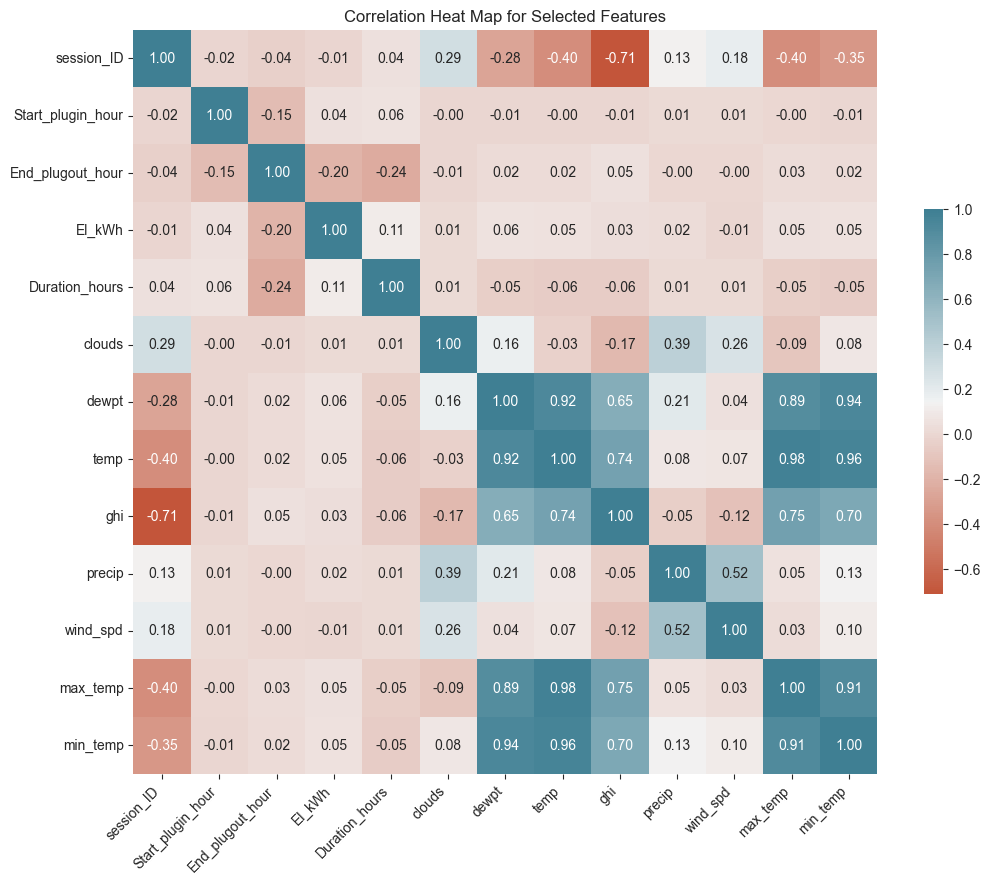

In [74]:
# subset the dataframe
df_subset = df_merged[columns_to_keep]

# select only the numeric columns for the correlation matrix
numeric_df = df_subset.select_dtypes(include=[np.number])

# calculate the correlation matrix for the subset
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap = sns.diverging_palette(20, 220, n=200),  
            square=True, 
            cbar_kws={"shrink": 0.5})
plt.title('Correlation Heat Map for Selected Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)  # Keep the y-axis labels horizontal

plt.savefig(f"{export_vis}/correlation_heatmap_merged_df.png")

plt.show()

## standout relationships

dewpt: temp (0.92), ghi (0.65), max_tem (0.89), min_temp (0.94)\
temp: ghi (0.74), max_temp (0.98), min_temp (0.96)\
ghi: max_temp (0.75), min_temp (0.70)\
precip: wind_spd (0.52)\

In [75]:
columns_to_keep = ['session_ID', 'User_type', 'Shared_ID', 'Start_plugin_hour', 'End_plugout_hour', 'El_kWh', 'Duration_hours', 'weekdays_plugin', 'Plugin_category', 'Duration_category', 'clouds', 'temp', 'ghi', 'precip', 'wind_spd']

In [76]:
df_merged = df_merged[columns_to_keep]
df_merged.head()

,session_ID,User_type,Shared_ID,Start_plugin_hour,End_plugout_hour,El_kWh,Duration_hours,weekdays_plugin,Plugin_category,Duration_category,clouds,temp,ghi,precip,wind_spd
2018-12-21,1,Private,Not_Shared,10,10.0,0.30,0.050000,Friday,late morning (9-12),Less than 3 hours,55,-0.5,3,0.0,2.4
2018-12-21,2,Private,Not_Shared,10,10.0,0.87,0.136667,Friday,late morning (9-12),Less than 3 hours,55,-0.5,3,0.0,2.4
2018-12-21,3,Private,Not_Shared,11,19.0,29.87,8.216389,Friday,late morning (9-12),Between 6 and 9 hours,55,-0.5,3,0.0,2.4
2018-12-22,4,Private,Not_Shared,16,16.0,15.56,24.419722,Saturday,late afternoon (15-18),More than 18 hours,61,-2.2,3,0.0,1.9
2018-12-24,5,Private,Not_Shared,22,23.0,3.62,0.970556,Monday,late evening (21-midnight),Less than 3 hours,100,1.1,3,22.0,3.8


In [78]:
# check for duplicates
duplicates = df_merged.duplicated()
duplicates = duplicates.sum()

if duplicates == 0:
    print("there are no duplicate rows.")
else:
    print(f"there are {duplicates} duplicate rows.")

there are no duplicate rows.


In [79]:
# check for missing values
missing = df_merged.isnull().sum()
missing = missing[missing > 0]

if missing.empty:
    print("there are no missing values.")
else: 
    print("features with missing values and their count:")
    print(missing)

there are no missing values.


In [83]:
unique_values = {column: df_merged[column].unique() for column in df_merged.columns}
display(unique_values)

{'session_ID': array([   1,    2,    3, ..., 6876, 6877, 6878]),
 'User_type': array(['Private', 'Shared'], dtype=object),
 'Shared_ID': array(['Not_Shared', 'Shared-7', 'Shared-12', 'Shared-5', 'Shared-6',
        'Shared-11', 'Shared-4', 'Shared-2', 'Shared-3', 'Shared-8',
        'Shared-1', 'Shared-10', 'Shared-9'], dtype=object),
 'Start_plugin_hour': array([10, 11, 16, 22, 23, 18,  8, 19, 15, 17, 20, 12, 13, 21,  2, 14,  9,
         4,  0,  7,  1,  6,  3,  5]),
 'End_plugout_hour': array([10., 19., 16., 23., 17., 21., 20., 15., 11.,  9.,  0.,  8., 13.,
        12., 18., 22., 14.,  6.,  7.,  5.,  2.,  1.,  4.,  3.]),
 'El_kWh': array([ 0.3 ,  0.87, 29.87, ..., 55.29,  0.92,  1.01]),
 'Duration_hours': array([0.05      , 0.13666667, 8.21638889, ..., 3.18222222, 1.20388889,
        3.18416667]),
 'weekdays_plugin': array(['Friday', 'Saturday', 'Monday', 'Tuesday', 'Wednesday', 'Sunday',
        'Thursday'], dtype=object),
 'Plugin_category': array(['late morning (9-12)', 'late after

## scatterplots

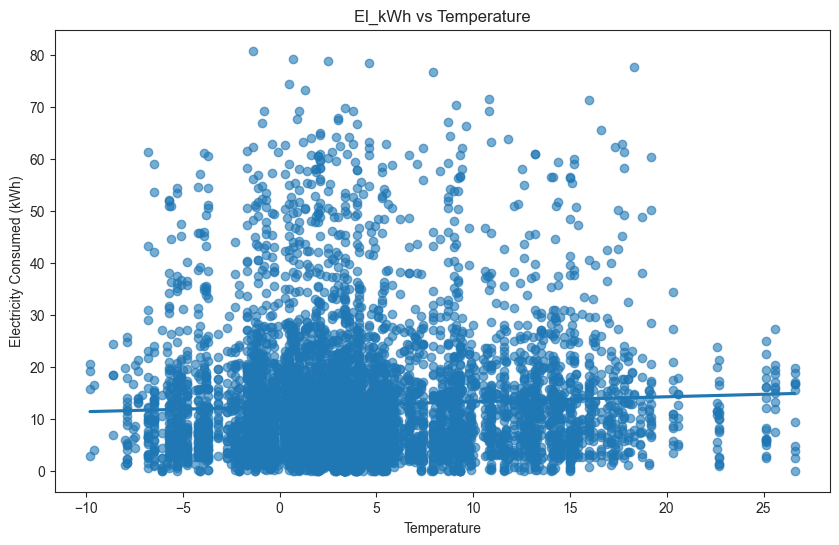

In [90]:
# scatter plot for El_kWh against temp
plt.figure(figsize=(10, 6))

scatter_plot = sns.regplot(x='temp', y='El_kWh', data=df_merged, ci=None, scatter_kws={'alpha':0.6})

plt.title('El_kWh vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('Electricity Consumed (kWh)')

# save the figure
plt.savefig(f'{export_vis}/el_kwh_vs_temperature_dfmerged.png')

plt.show()

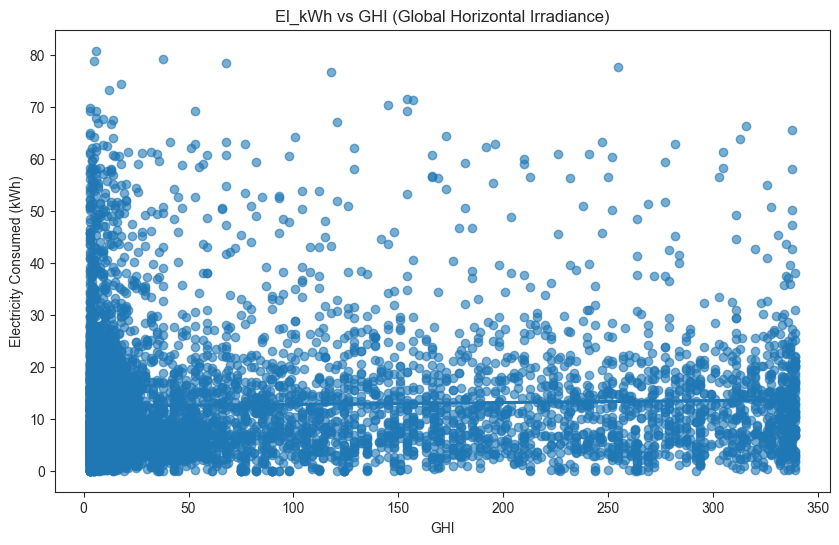

In [91]:
# scatter plot for El_kWh against ghi
plt.figure(figsize=(10, 6))

scatter_plot = sns.regplot(x='ghi', y='El_kWh', data=df_merged, ci=None, scatter_kws={'alpha':0.6})

plt.title('El_kWh vs GHI (Global Horizontal Irradiance)')
plt.xlabel('GHI')
plt.ylabel('Electricity Consumed (kWh)')

# save the figure
plt.savefig(f'{export_vis}/el_kwh_vs_ghi_dfmerged.png')

plt.show()

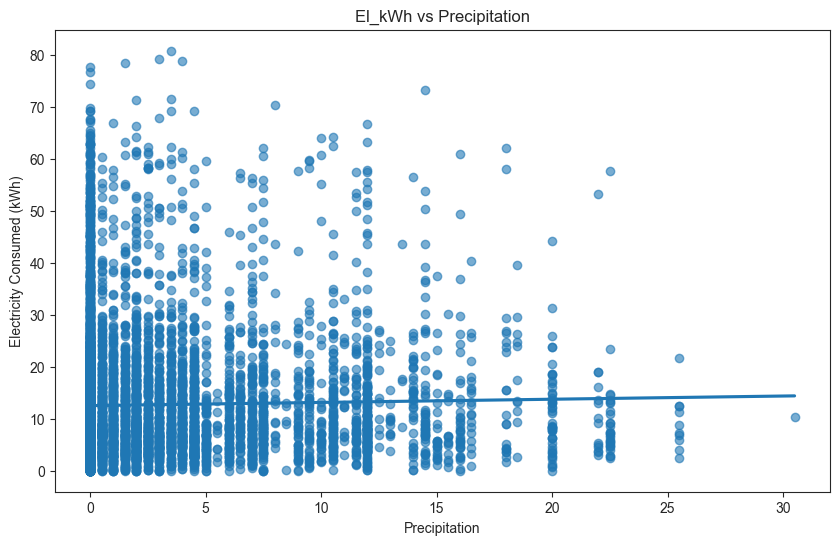

In [92]:
# scatter plot for El_kWh against precip
plt.figure(figsize=(10, 6))

scatter_plot = sns.regplot(x='precip', y='El_kWh', data=df_merged, ci=None, scatter_kws={'alpha':0.6})

plt.title('El_kWh vs Precipitation')
plt.xlabel('Precipitation')
plt.ylabel('Electricity Consumed (kWh)')

# save the figure
plt.savefig(f'{export_vis}/el_kwh_vs_precipitation_dfmerged.png')

plt.show()

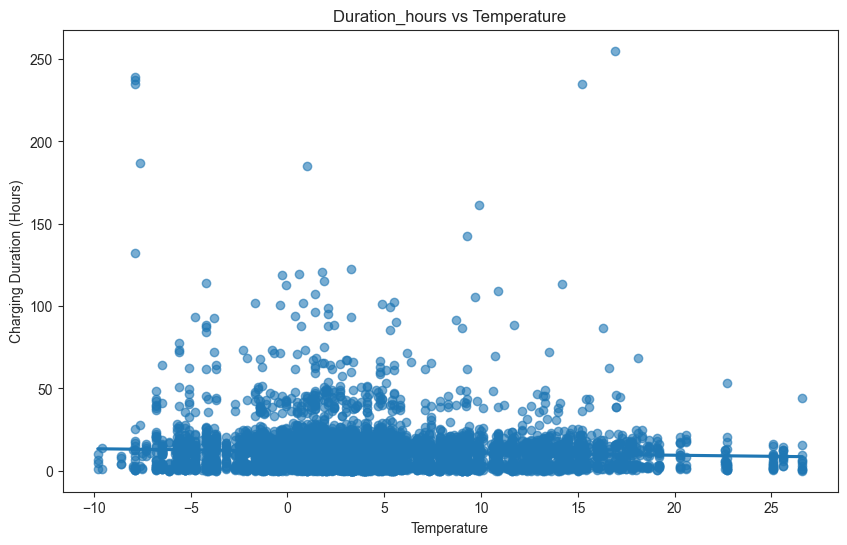

In [93]:
# scatter plot for Duration_hours against temp
plt.figure(figsize=(10, 6))

scatter_plot = sns.regplot(x='temp', y='Duration_hours', data=df_merged, ci=None, scatter_kws={'alpha':0.6})

plt.title('Duration_hours vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('Charging Duration (Hours)')

# save the figure
plt.savefig(f'{export_vis}/duration_hours_vs_temperature_dfmerged.png')

plt.show()

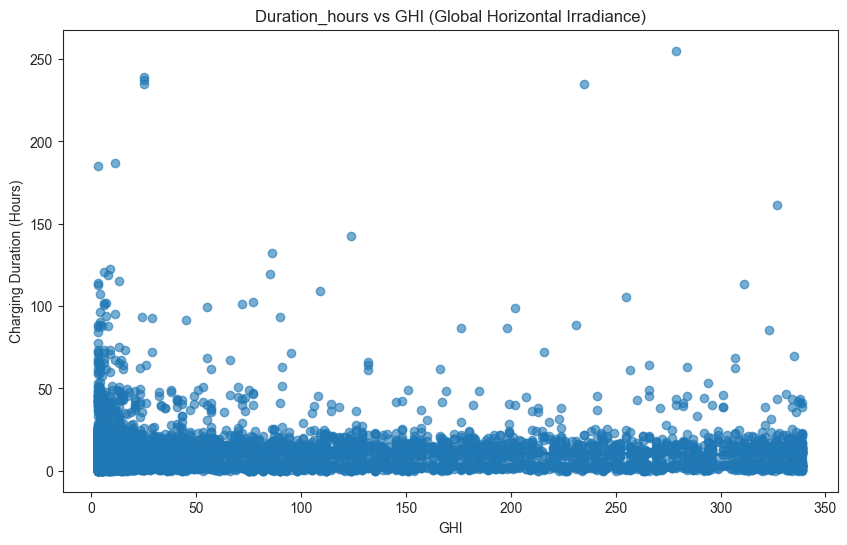

In [94]:
# scatter plot for Duration_hours against ghi
plt.figure(figsize=(10, 6))

scatter_plot = sns.regplot(x='ghi', y='Duration_hours', data=df_merged, ci=None, scatter_kws={'alpha':0.6})

plt.title('Duration_hours vs GHI (Global Horizontal Irradiance)')
plt.xlabel('GHI')
plt.ylabel('Charging Duration (Hours)')

# save the figure
plt.savefig(f'{export_vis}/duration_hours_vs_ghi_dfmerged.png')

plt.show()

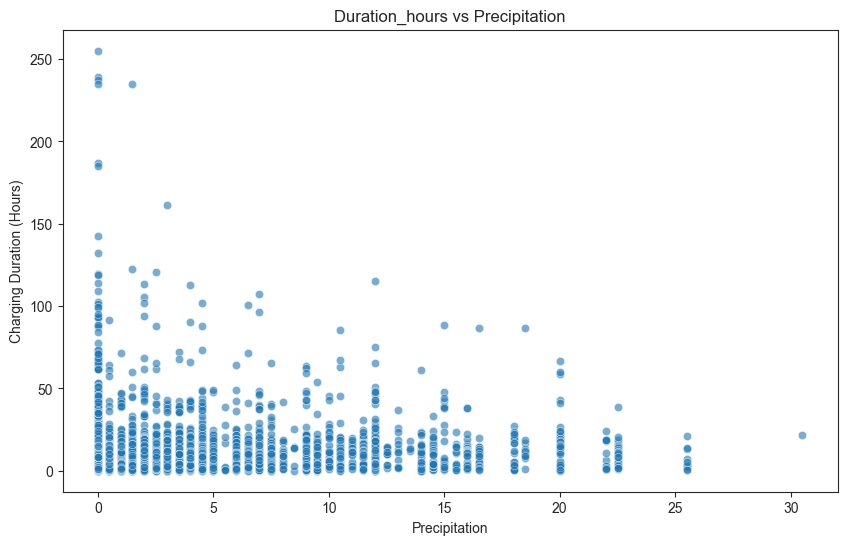

In [89]:
# scatter plot for Duration_hours against precip
plt.figure(figsize=(10, 6))

scatter_plot = sns.regplot(x='precip', y='Duration_hours', data=df_merged, ci=None, scatter_kws={'alpha':0.6})

plt.title('Duration_hours vs Precipitation')
plt.xlabel('Precipitation')
plt.ylabel('Charging Duration (Hours)')

# save the figure
plt.savefig(f'{export_vis}/duration_hours_vs_precipitation_dfmerged.png')

plt.show()